## Initialization

In [1]:
import os, glob
import numpy as np
import scipy as sp
import mvpa2.suite as mvpa2
import itertools, statsmodels
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline

/home/hangyee/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def show_cluster(data,ds,options=""):
    result_file = mvpa2.map2nifti(ds,data=data)
    result_file.to_filename('temp_result.nii.gz')
    !{'cluster --in=temp_result.nii.gz --mm ' + options}  

def ensure_dir(ed):
    try: 
        os.makedirs(ed)
    except OSError:
        if not os.path.isdir(ed):
            raise
            
def center_and_scale(ex):
    ex -= np.mean(ex,axis=0)
    ex_norm = np.linalg.norm(ex)
    if ex_norm != 0:
        ex /= ex_norm
    return ex

def remove_file(rf):
    if os.path.isfile(rf):
        os.remove(rf)

In [3]:
stim_type = ['ad1','ad2','movie']
dv_type = 'liking'

stim_n = { 'movie':18, 'ad1': 35, 'ad2': 35 }
pp_n = { 'movie':28, 'ad1': 40, 'ad2': 20 }

# Length of stimuli (in seconds)
stim_length = {
    'movie':[125,131,130,66,142,134,150,143,141,131,141,142,147,143,145,136,137,133],
    'ad1':[32,32,32,42,40,30,45,25,30,39,60,40,40,40,45,57,47,42,45,45,45,45,40,25,46,40,39,30,35,35,60,31,65,32,40],
    'ad2':[32,32,32,42,40,30,45,25,30,39,60,40,40,40,45,57,47,42,45,45,45,45,40,25,46,40,39,30,35,35,60,31,65,32,40]
}

# Out-of-sample liking
stim_dv = {
    'ad1': np.array([0.51745014, 0.58938746, 0.60327635, 0.67485755, 0.6965812 ,
       0.34294872, 0.5519943 , 0.32977208, 0.36146724, 0.64351852,
       0.61324786, 0.53098291, 0.49821937, 0.68447293, 0.66061254,
       0.67343305, 0.68554131, 0.66915954, 0.66168091, 0.66310541,
       0.61716524, 0.64850427, 0.43447293, 0.50391738, 0.68874644,
       0.67663818, 0.66025641, 0.32086895, 0.59793447, 0.55413105,
       0.65669516, 0.58725071, 0.62535613, 0.37286325, 0.5548433 ]), 
    'ad2': np.array([0.51745014, 0.58938746, 0.60327635, 0.67485755, 0.6965812 ,
       0.34294872, 0.5519943 , 0.32977208, 0.36146724, 0.64351852,
       0.61324786, 0.53098291, 0.49821937, 0.68447293, 0.66061254,
       0.67343305, 0.68554131, 0.66915954, 0.66168091, 0.66310541,
       0.61716524, 0.64850427, 0.43447293, 0.50391738, 0.68874644,
       0.67663818, 0.66025641, 0.32086895, 0.59793447, 0.55413105,
       0.65669516, 0.58725071, 0.62535613, 0.37286325, 0.5548433 ]),
    'movie': np.array([2.19791667,  2.77604167,  2.44791667,  1.734375  ,  2.73958333,
        2.36458333,  3.30729167,  1.69270833,  2.        ,  1.625     ,
        1.89583333,  3.50520833,  3.38541667,  1.78645833,  3.03645833,
        1.14583333,  3.3125    ,  2.55208333]),
}

# In-sample liking
stim_in_dv = {
    'ad1': np.array([0.546875,0.544792,0.596875,0.648958,0.642708,0.252083,
                      0.565625,0.307292,0.301042,0.588542,0.657292,0.6,0.579167,
                      0.740625,0.661458,0.54375,0.579167,0.53125,0.477083,0.48125,
                      0.471875,0.48125,0.389583,0.529167,0.682292,0.6375,0.6375,0.3125,
                      0.565625,0.669792,0.677083,0.604167,0.613542,0.389583,0.586458]),
    'ad2': np.array([0.502083,0.46875,0.625,0.60625,0.629167,0.254167,
                      0.491667,0.3875,0.427083,0.597917,0.560417,0.535417,
                      0.5125,0.727083,0.710417,0.575,0.558333,0.535417,0.491667,
                      0.572917,0.485417,0.55,0.44375,0.429167,0.654167,0.677083,
                      0.627083,0.4125,0.579167,0.529167,0.664583,0.6,0.629167,0.420833,0.577083]),
    'movie': np.array([2.357143,2.375,2.446429,2.25,2.232143,2.571429,2.767857,2.625,1.857143,2.017857,
                       2.285714,2.892857,3.375,2.464286,2.839286,2.267857,3.196429,2.303571])
}

## 2.6. Whole-brain analysis of neural similarity

In [ ]:
# For each study
for st in stim_type: 
    
    # For each stimulus
    for stim in range(stim_n[st]):

        # For each searchlight radius
        for radius in [0,1,2,3,4]:

            mask_file = 'mask/'+stim_type+'/brain.nii.gz'

            mask_ds = mvpa2.fmri_dataset(mask_file,mask=mask_file)
            searchlight = mvpa2.IndexQueryEngine(voxel_indices=mvpa2.Sphere(radius))
            searchlight.train(mask_ds)

            interval = mask_ds.nfeatures / 100

            print "Stim %d" % stim

            if (stim_type == 'movie'):
                scan_files = glob.glob('extract/'+stim_type+'/m%02d/*.nii.gz' % stim)
            else:
                scan_files = glob.glob('extract/'+stim_type+'/AD%02d/*.nii.gz' % stim)

            scan_files.sort()

            n_subjs = len(scan_files)

            results = np.zeros([n_subjs*(n_subjs-1)/2, mask_ds.nfeatures])
            null_results = np.zeros([n_subjs*(n_subjs-1)/2, mask_ds.nfeatures])

            subj_ds = []
            for sf in scan_files:
                subj_ds.append(mvpa2.fmri_dataset(sf,mask=mask_file))

            stim_len = subj_ds[0].nsamples

            for m in range(mask_ds.nfeatures):
                voxel_mask = searchlight[m]

                extracted_vectors = []
                for ds in subj_ds:
                    vector = np.copy(ds.samples[:,voxel_mask])
                    extracted_vectors.append(center_and_scale(vector))

                for n, (s1, s2) in enumerate(itertools.combinations(range(n_subjs),2)):
                    results[n,m] = np.linalg.norm(extracted_vectors[s1]-extracted_vectors[s2])
                    null_results[n,m] = np.linalg.norm(extracted_vectors[s1]-np.roll(extracted_vectors[s2],np.random.randint(1,stim_len),axis=0))

                if (m % interval == 0):
                    print "*",

            print " "

            ensure_dir(output_dir+'s%d' % radius)

            mean_result = np.mean(results,axis=0)
            mean_result_file = mvpa2.map2nifti(mask_ds,data=mean_result)
            mean_result_file.to_filename(output_dir+'s%d/AD%02d.nii' % (radius,stim))

            ensure_dir(output_dir+'t%d' % radius)

            mean_result = sp.stats.ttest_rel(results,null_results,axis=0).statistic
            mean_result_file = mvpa2.map2nifti(mask_ds,data=mean_result)
            mean_result_file.to_filename(output_dir+'t%d/AD%02d.nii' % (radius,stim))

## 3.1. Synchronized neural activities during video viewing

In [5]:
from scipy.stats import t,norm

radius = 2
t_result = []

for st in ['ad1','ad2']:
    print st
    t_files = glob.glob('../isc/'+st+'/t'+str(radius)+'/*.nii')
    mask_file = '../mask/'+st+'/brain.nii.gz'

    t_ds = mvpa2.fmri_dataset(t_files,mask=mask_file)

    df = (pp_n[st]*(pp_n[st]-1)/2) - 1
    tval = np.mean(-1*t_ds.samples,axis=0) 
    prob = t.sf(np.abs(tval),df)*2
        
    t_result.append(tval)
    
    reject,pval,alphas,alphab = statsmodels.sandbox.stats.multicomp.multipletests(prob, alpha=.05, method='fdr_bh', returnsorted=False)

    print "POS"
    show_cluster(tval[reject],t_ds[:,reject],'--thresh=0.001 --othresh=output/'+st+'_t'+str(radius)+'_pos.nii.gz')

    print "NEG"
    show_cluster(tval[reject],t_ds[:,reject],'--min --thresh=-0.001 --othresh=output/'+st+'_t'+str(radius)+'_neg.nii.gz')

ad1
 * Please note: warnings are printed only once, but underlying problem might occur many times *
POS
Cluster Index	Voxels	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)
16	16215	25.7	-48	-73	5.6	0.968	-56.1	8.67
15	539	6.98	0	17	41.6	0.607	19.3	36.2
14	142	3.3	39	44	20	36.2	51.5	11.8
13	100	3.93	-36	53	12.8	-34.1	51.9	12.4
12	57	4.4	-42	-1	52.4	-41.8	-0.0714	51.9
11	45	3.64	51	-1	48.8	49.8	-1.38	47.2
10	34	3.61	0	50	-16	0.263	48.3	-16.4
9	29	2.88	-48	-64	-37.6	-45.6	-65.1	-38.8
8	16	3.4	12	-49	-48.4	13.7	-47.9	-47.8
7	13	2.9	-12	-49	-48.4	-12.3	-47.1	-46.8
6	13	2.64	3	-4	9.2	1.42	-3.78	7.83
5	10	2.81	21	-7	-16	21.6	-6.1	-15.3
4	3	2.55	-27	-10	52.4	-26	-8.03	52.4
3	3	2.51	-27	-10	59.6	-29	-8.02	60.8
2	2	2.41	0	-55	-37.6	-1.5	-56.5	-39.4
1	2	2.51	39	32	34.4	37.5	33.5	32.6
NEG
Cluster Index	Voxels	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)
ad2
POS
Cluster Index	Voxels	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)

In [6]:
np.corrcoef(t_result[0],t_result[1])[0][1]

0.9053815967093515

## 3.2. Neural similarity and activation correlate with out-of-sample preference

### 3.2.1. Whole-brain analysis

In [7]:
null_n = 10000
covariate_length = True

for radius in [2]:
    print "Radius %d"%radius
    
    for st in ['ad1','ad2']:
        ensure_dir('output/'+dv_type)
        
        print st,

        dv = np.copy(stim_dv[st])
        ad_length = np.array(stim_length[st])

        data_files = glob.glob('../isc/'+st+'/s'+str(radius)+'/*.nii')
        data_files.sort()
        
        data_files = data_files[:stim_n[st]]
        dv = dv[:stim_n[st]]
        ad_length = ad_length[:stim_n[st]]

        mask_file = '../mask/'+st+'/brain.nii.gz'

        ds = mvpa2.fmri_dataset(data_files,mask=mask_file)
                
        if st == 'movie':
            dv = dv[np.arange(18)!=3]
            ds = ds[np.arange(18)!=3]
            ad_length = ad_length[np.arange(18)!=3]
        
        if covariate_length:
            stim_length_regress = np.vstack([ad_length,np.ones(len(ad_length))]).T
            
            ds_regress, residuals, rank, s = np.linalg.lstsq(stim_length_regress,ds.samples)
            ds.samples -= stim_length_regress.dot(ds_regress)
            
            dv_regress, residuals, rank, s = np.linalg.lstsq(stim_length_regress,dv)
            dv -= stim_length_regress.dot(dv_regress)

        my = np.mean(dv)
        mx = np.mean(ds.samples,axis=0)

        xm, ym = ds.samples - mx, dv - my
        
        r = np.empty(ds.nfeatures)
        r.fill(np.nan)
        
        r_num = np.sum((xm.T * ym.T).T,axis=0)
        
        xm_sq = np.sum(xm ** 2,axis=0)
        ym_sq = np.sum(ym ** 2)
        r_den = np.sqrt(xm_sq * ym_sq)
        
        mask = (r_den != 0)
        r[mask] = r_num[mask] / r_den[mask]
                
        null_r = np.empty((null_n,len(r)))
        null_r.fill(np.nan)
        
        for i in range(null_n):
            if i % 500 == 0:
                print "*",
            np.random.shuffle(ym)
            null_r[i,:] = np.sum((xm.T * ym.T).T,axis=0)
        
        null_r[:,mask] /= r_den[mask]
       
        result_file = mvpa2.map2nifti(ds,data=r)
        result_file.to_filename('output/'+dv_type+'/'+st+'_s'+str(radius)+'.nii.gz')
        
        print "Estimating p-values..."
        
        p_onetail = np.empty(ds.nfeatures)
        p_onetail.fill(np.nan)
        
        p_onetail[mask] = np.sum(null_r[:,mask] < r[mask],axis=0).astype(float) / null_n
        p_twotail = 1-(np.abs(p_onetail-0.5)*2)
        
        result_file = mvpa2.map2nifti(ds,data=p_twotail)
        result_file.to_filename('output/'+dv_type+'/'+st+'_p_s'+str(radius)+'.nii.gz')
        
        del null_r

Radius 2
ad1

/home/hangyee/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/hangyee/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


 * * * * * * * * * * * * * * * * * * * * Estimating p-values...
ad2 * * * * * * * * * * * * * * * * * * * * Estimating p-values...


In [8]:
r_result = []

for radius in [2]:
    print "Radius %d"%radius
    
    for st in ['ad1','ad2']:
        
        print st

        mask_file = '../mask/'+st+'/brain.nii.gz'
        
        ds = mvpa2.fmri_dataset(mask_file,mask=mask_file)
        r = mvpa2.fmri_dataset('output/'+dv_type+'/'+st+'_s'+str(radius)+'.nii.gz',mask=mask_file).samples[0]
        p = mvpa2.fmri_dataset('output/'+dv_type+'/'+st+'_p_s'+str(radius)+'.nii.gz',mask=mask_file).samples[0]

        ds_masked = ds[:,~np.isnan(r)]
        r_masked = r[~np.isnan(r)]
        p_masked = p[~np.isnan(r)]
        
        p_masked[p_masked == 0] = 1/null_n
        
        r_result.append(np.arctanh(r_masked))
        
        reject,pval,alphas,alphab = statsmodels.sandbox.stats.multicomp.multipletests(p_masked, alpha=.05, method='fdr_bh', returnsorted=False)
        
        print "POS"
        show_cluster(r_masked[reject],ds_masked[:,reject],'--thresh=0.001 --osize=output/'+dv_type+'/'+st+'_s'+str(radius)+'_cluster_pos.nii.gz')
        
        print "NEG"
        show_cluster(r_masked[reject],ds_masked[:,reject],'--min --thresh=-0.001 --osize=output/'+dv_type+'/'+st+'_s'+str(radius)+'_cluster_neg.nii.gz')
    
for radius in [2]:
    print "Radius %d"% radius
    for cluster in ['pos','neg']:

        mask_file = '../mask/ad1/brain.nii.gz'

        ds_file = ['output/'+dv_type+'/'+st+'_s'+str(radius)+'_cluster_'+cluster+'.nii.gz' for st in ['ad1','ad2']]
        ds = mvpa2.fmri_dataset(ds_file,mask=mask_file)

        mutual = np.all(ds.samples,axis=0)

        print cluster
        show_cluster(mutual[mutual>0],ds[:,mutual>0],'--osize=output/'+dv_type+'/ad_s'+str(radius)+'_cluster_'+cluster+'.nii.gz --thresh=1')    

print sp.stats.pearsonr(r_result[0],r_result[1])

Radius 2
ad1
POS
Cluster Index	Voxels	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)
22	13	0.577	-18	-91	30.8	-20	-91.5	27.8
21	12	0.607	48	-19	56	47.3	-19.7	56.3
20	11	0.587	39	-22	45.2	36.3	-21.5	46.8
19	7	0.577	-18	8	5.6	-15.5	8.43	4.06
18	7	0.571	15	-100	16.4	17.1	-98.7	17
17	5	0.553	30	-13	66.8	30.6	-12.4	68.2
16	4	0.616	0	-40	-62.8	0.833	-40	-63.7
15	3	0.539	9	-7	48.8	9.98	-5.05	48.8
14	3	0.562	9	-22	-19.6	7.05	-22	-18.4
13	3	0.614	-12	-1	41.6	-11	-1	40.5
12	2	0.545	-27	-19	48.8	-27	-19	47.1
11	2	0.538	-48	-19	41.6	-46.5	-20.5	41.6
10	2	0.513	-42	-28	23.6	-40.5	-26.5	21.8
9	2	0.566	6	-19	-30.4	6	-19	-32.1
8	2	0.534	-3	20	16.4	-1.51	20	16.4
7	1	0.507	15	5	70.4	15	5	70.4
6	1	0.521	15	-13	16.4	15	-13	16.4
5	1	0.517	-6	-10	-16	-6	-10	-16
4	1	0.531	12	-58	-23.2	12	-58	-23.2
3	1	0.51	-30	-40	-37.6	-30	-40	-37.6
2	1	0.512	27	-55	-37.6	27	-55	-37.6
1	1	0.566	-15	2	66.8	-15	2	66.8
NEG
Cluster Index	Voxels	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	CO

### 3.2.2. ROI analysis

Calculate PCA component weights

 ad1
Stim 1

/home/hangyee/anaconda2/lib/python2.7/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 (20680, 633)


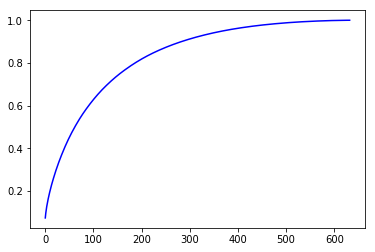

0.4512201124477622 0.6281188128915652 0.818205004410368


In [10]:
from sklearn.decomposition import PCA

st = 'ad1'
print st

dv = stim_dv[st]

mask_file = '../mask/'+st+'/brain.nii.gz'    
roi_file = '../mask/roi/liking_ad_s2_isc.nii.gz'

remove_file('temp_roi.nii.gz')
cmd = '3dresample -master '+mask_file+' -inset '+roi_file+' -prefix temp_roi.nii.gz'
!{cmd}

all_ds = []

print "Stim",

for i in range(stim_n[st]):
    print "%d" % (i+1),

    if (st == 'movie'):
        scan_files = glob.glob('../extract/'+st+'/m%02d/*.nii.gz' % (i+1))
    else:
        scan_files = glob.glob('../extract/'+st+'/AD%02d/*.nii.gz' % (i+1))
    scan_files.sort()

    for sf in scan_files:
        ds = mvpa2.fmri_dataset(sf,mask='temp_roi.nii.gz')
        centered_ds = center_and_scale(ds.samples)
        all_ds.append(centered_ds)

all_ds = np.vstack(all_ds)
print all_ds.shape

pca = PCA()
pca.fit(all_ds)
np.save('output/'+st+'_pca.npy',pca.components_)

plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_),'b-')
plt.show()

print np.cumsum(pca.explained_variance_ratio_)[50], np.cumsum(pca.explained_variance_ratio_)[100], np.cumsum(pca.explained_variance_ratio_)[200]

In [ ]:
mask_file = 'mask/ad1/brain.nii.gz'
roi_file = '../mask/roi/liking_ad_s2_isc.nii.gz'

ds = mvpa2.fmri_dataset(mask_file,mask=roi_file)
pca_nii = mvpa2.map2nifti(ds,data=np.load('output/'+st+'_pca.npy'))
pca_nii.to_filename('output/'+st+'_pca.nii.gz')

In [ ]:
mask_file = 'mask/movie/brain.nii.gz'

pca_file = 'output/'+st+'_pca.nii.gz'
out_pca_file = 'output/'+st+'_pca_movie.nii.gz'

cmd = '3dresample -master '+mask_file+' -inset '+pca_file+' -prefix '+out_pca_file
!{cmd}

Similarity analysis after PCA

In [ ]:
from scipy.spatial.distance import pdist

n_components = [50,100,200]
distance = ['euclidean','correlation','cityblock']

for st in ['ad1','ad2','movie']:

    print st

    header = ['ad','length','dv','in_dv']
    
    dv = stim_dv[st]
    in_dv = stim_in_dv[st]

    roi_names = ['isc_liking']
    roi_files = ['mask/roi/liking_ad_s2_isc.nii.gz']
    
    mask_file = 'mask/'+st+'/brain.nii.gz'       
        
    add_fa = {}
    for n,roi_file in enumerate(roi_files):

        remove_file('temp_roi'+str(n)+'.nii.gz')
        
        cmd = '3dresample -master '+mask_file+' -inset '+roi_file+' -prefix temp_roi'+str(n)+'.nii.gz'
        !{cmd}

        add_fa[roi_names[n]] = 'temp_roi'+str(n)+'.nii.gz'
        
    remove_file('temp_mask.nii.gz')
    
    cmd = 'fslmaths temp_roi0.nii.gz '
    for n in range(1,len(roi_files)):
        cmd += '-add temp_roi'+str(n)+'.nii.gz '
    cmd += '-bin temp_mask.nii.gz'
    !{cmd}

    if st == 'ad1':
        pca_nii = mvpa2.fmri_dataset('ad1_pca.nii.gz',mask='temp_mask.nii.gz')
    elif st == 'ad2':
        pca_nii = mvpa2.fmri_dataset('ad1_pca.nii.gz',mask='temp_mask.nii.gz')        
    elif st == 'movie':
        pca_nii = mvpa2.fmri_dataset('ad1_pca_movie.nii.gz',mask='temp_mask.nii.gz')        

    pca = pca_nii.samples
    
    results = [[] for i in range(stim_n[st])]

    for i in range(stim_n[st]):
        print "Stim %d" % (i+1),

        if (st == 'movie'):
            scan_files = glob.glob('extract/'+st+'/m%02d/*.nii' % (i+1))
        else:
            scan_files = glob.glob('extract/'+st+'/AD%02d/*.nii' % (i+1))
        scan_files.sort()

        subj_ds = []
        for sf in scan_files:
            subj_ds.append(mvpa2.fmri_dataset(sf,mask='temp_mask.nii.gz',add_fa=add_fa))

        for nc in n_components:
            print nc,
            extracted_vectors = []
            for ds in subj_ds:
                vector = center_and_scale(np.copy(ds.samples[:,ds.fa['isc_liking'].value > 0]))
                pca_vector = center_and_scale(np.dot(vector, pca[:nc,:].T))
                extracted_vectors.append(np.ravel(pca_vector))
            
            for dist in distance:
                results[i].append(np.mean(pdist(np.array(extracted_vectors),metric=dist)))

        print 'raw',
        extracted_vectors = []
        for ds in subj_ds:
            vector = center_and_scale(np.copy(ds.samples[:,ds.fa['isc_liking'].value > 0]))
            extracted_vectors.append(np.ravel(vector))

        for dist in distance:
            results[i].append(np.mean(pdist(np.array(extracted_vectors),metric=dist)))
            
        print " "
        
    for nc in n_components:    
        for dist in distance:
            header.append(dist+"_%d"%nc)
    for dist in distance:        
        header.append(dist+"_raw")

    results_array = np.array(results)
    np.savetxt('output/'+st+'_total_pdist_pca.csv',np.vstack([np.arange(1,stim_n[st]+1),stim_length[st],np.array(dv),in_dv,results_array.T]).T,fmt='%f',delimiter=',',header=','.join(header),comments='')

    cor = []
    for i in range(results_array.shape[1]):
        cor.append(sp.stats.pearsonr(dv,results_array[:,i]))

    for h,c in zip(header[4:],cor):
        print h,c